#### Постановка задачи.

Представьте, что вы работаете в компании, которая разрабатывает мобильные игры. К вам пришел менеджер с рядом задач по исследованию нескольких аспектов мобильного приложения:

В первую очередь, его интересует показатель retention. Напишите функцию для его подсчета.

Помимо этого, в компании провели A/B тестирование наборов акционных предложений. На основе имеющихся данных определите, какой набор можно считать лучшим и на основе каких метрик стоит принять правильное решение.

Предложите метрики для оценки результатов последнего прошедшего тематического события в игре.

#### Задача 1:
    
Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention 
игроков (по дням от даты регистрации игрока). Данные и имеют следующую структуру:

reg_data.csv – данные о времени регистрации
auth_data.csv - данные о времени захода пользователей в игру

#### Алгоритм решения задачи:

импортировать библиотеки;
прочитать данные;
проверить в них наличие дубликатов и пропущенных значений;
написать функцию подсчета retention;
протестировать работу функции;
визуализировать retention в Jupyter;
визуалиировать retention в Tableau.

#### Импортирую необходимые библиотеки:

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
import datetime as dt
import warnings
import time
from calculate_retention import CalculateRetention
%matplotlib inline

#### Загружаю данные:

regs - данные о регистрации пользователей

auth - данные о входе в Приложение.

In [ ]:
#### Загружаю датасеты:

In [17]:
regs = pd.read_csv('./datasets/KarpovCourses/final/1/reg_data.csv', sep=';')

auth = pd.read_csv('./datasets/KarpovCourses/final/1/auth_data.csv', sep=';')

#### Эта функция мне нужна чтобы сходу понимать shape датафреймов и содержат ли какие-то колонки дубликаты:

In [3]:
def datasets_params(df1, df2):
    
    params = {'regs': ['shape', df1.shape, 'duplicated', df1.duplicated().sum()], 
              'auth': ['shape', df2.shape, 'duplicated', df2.duplicated().sum()],
             }
 
    return print(pd.DataFrame(params))

#### Смотрю на формы датасетов и на наличие в них дубликатов:

In [4]:
datasets_params(regs, auth)

           regs          auth
0         shape         shape
1  (1000000, 2)  (9601013, 2)
2    duplicated    duplicated
3             0             0


####  Проверяю на наличие пропущенных значений:

In [47]:
regs.isna().sum()

reg_ts    0
uid       0
dtype: int64

In [48]:
auth.isna().sum()

auth_ts    0
uid        0
dtype: int64

In [49]:
regs.head(2)

,reg_ts,uid
0,911382223,1
1,932683089,2


In [33]:
auth.head(2)

,auth_ts,uid
0,911382223,1
1,932683089,2


In [32]:
regs.dtypes

reg_ts    int64
uid       int64
dtype: object

#### Создаю функцию для расчета retention:

In [18]:
def retention(regs, auth, start, stop): 

    # Соединяю датасеты:
    df = regs.merge(auth, how='left', on='uid')
    
    # Перевожу колонки из datastamp в datetime:
    df.reg_ts = pd.to_datetime(df.reg_ts, unit='s')
    df.auth_ts = pd.to_datetime(df.auth_ts, unit='s')
    
    # Выделяю дату:
    df.reg_ts = df.reg_ts.dt.date
    df.auth_ts = df.auth_ts.dt.date
    
   # Повторно перевожу колонки из datastamp в datetime (автоматически стали object):
    df.reg_ts = pd.to_datetime(df.reg_ts)
    df.auth_ts = pd.to_datetime(df.auth_ts)
    
    # Оставляю данные в выбранном интервале:
    df = df.query('reg_ts >=@start and reg_ts <=@stop')
    
    # Считаю количество дней, прошедших с момента регистрации:  
    df['days_after_reg'] = (df.auth_ts - df.reg_ts).dt.days + 1
    
    # Создаю когорты:
    cohort_data = df.groupby(['reg_ts', 'days_after_reg']) \
                    .uid.apply(pd.Series.nunique) \
                    .reset_index()

    # Считаю retention:
    cohort_counts = cohort_data.pivot(index='reg_ts', columns='days_after_reg', values='uid')
       
    return cohort_counts.divide(cohort_counts.iloc[:,0], axis=0) \
                        .round(3) \
                        .mul(100) \
                        .drop(cohort_counts.columns[0], axis=1)  

#### Считаю retention за тестовый период с 1 октября до 25 октября 2020:

In [114]:
retention = retention(regs, auth, '2020-10-1', '2020-10-25')

retention

days_after_reg,2,3,4,5,6,7,8,9,10,11,...,14,15,16,17,18,19,20,21,22,23
reg_ts,,,,,,,,,,,,,,,,,,,,,
2020-09-01,2.018,4.098,4.224,4.603,6.431,5.612,6.431,4.098,5.422,5.107,...,5.485,4.288,4.414,4.351,5.044,4.161,4.351,3.594,4.351,1.576
2020-09-02,2.519,3.904,4.660,5.668,6.234,7.116,6.297,4.849,4.093,5.668,...,4.345,4.975,5.290,4.156,4.849,3.904,3.715,4.660,2.645,NaN
2020-09-03,2.326,5.405,4.714,6.537,6.977,8.548,6.348,5.468,6.285,6.348,...,5.971,5.468,5.343,4.400,4.840,4.651,5.468,2.388,NaN,NaN
2020-09-04,2.009,3.641,3.641,5.148,6.403,7.282,4.959,5.336,4.331,5.650,...,5.587,4.394,4.520,4.520,4.269,4.771,2.637,NaN,NaN,NaN
2020-09-05,2.757,3.947,4.637,5.451,5.890,7.456,4.887,5.075,5.451,6.015,...,5.388,4.511,5.138,4.449,4.762,2.506,NaN,NaN,NaN,NaN
2020-09-06,3.127,4.315,5.441,5.629,5.879,6.817,6.066,5.816,5.503,4.878,...,5.191,5.503,4.565,4.816,2.564,NaN,NaN,NaN,NaN,NaN
2020-09-07,2.936,4.247,5.372,5.059,6.371,7.308,5.247,4.122,5.621,5.996,...,5.059,4.247,5.059,3.373,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-08,1.746,3.928,3.928,4.863,7.606,7.544,6.608,5.175,5.175,6.546,...,5.175,4.738,3.055,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-09,1.742,3.236,4.667,5.725,6.658,5.725,5.912,4.356,5.040,3.734,...,4.854,2.427,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Создаю функцию для визуализации retention:

In [106]:
def viz_retention(retention):
    
    retention.index = retention.index.strftime('%Y-%m-%d')
    plt.figure(figsize=(20,10))
    plt.title('Active users')
    ax = sns.heatmap(data=retention, annot=True, vmin=0.0)
    ax.set_yticklabels(retention.index)
    fig=ax.get_figure()
    return plt.show()

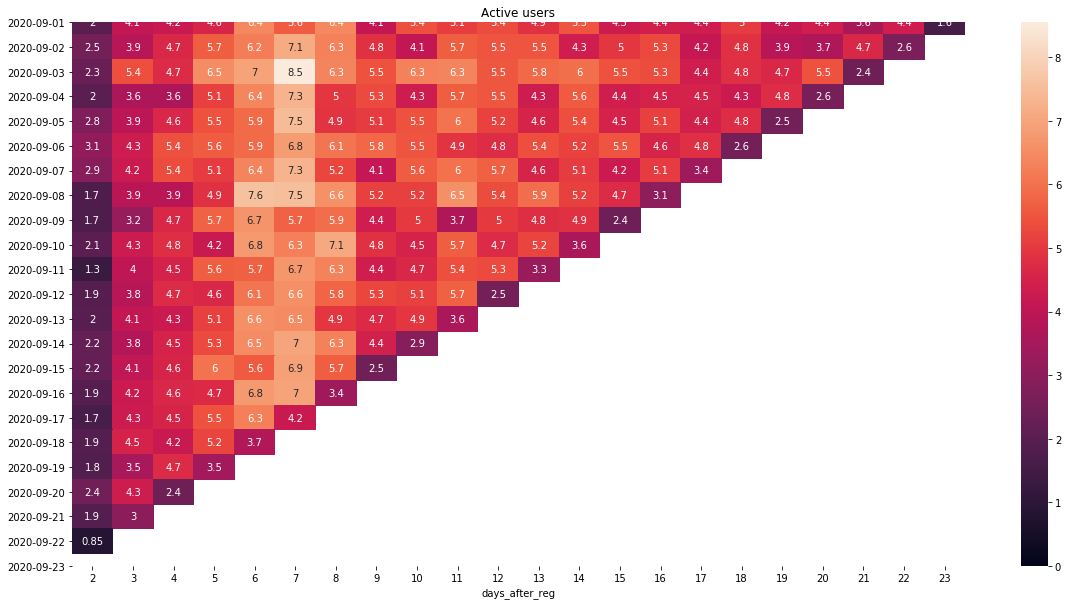

In [115]:
viz_retention(retention)

#### Вывод: 

Retention у Приложения очень низкий, необходимы мероприятия для повышения вовлеченности.

#### Задание 2

Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений. 
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. При этом в контрольной группе 1928 игроков из 202103 оказались платящими, а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

#### Алгоритм решения:

Импортирую библиотеки.
Загружаю датасеты.
Смотрю структуру, типы данных, проверяю на наличие дубликатов и пропущенных значений.
Формирую рабочий датафрейм из загруженных датасетов.
Провожу разделение датасета на тестовую и контрольную группы.
Выделяю основные метрики для анализа для принятия решения об эффективности изменений по результатам АБ-теста.
Проверяю насколько изменились основные параметры в тестовой группе относительно контрольной группы.
Строю боксплоты для того чтобы оценить выбросы.
Оцениваю наличие и величину выбросов и принимаю решение что с ними делать.
Проверяю тестовую и контрольную выборки на нормальность.
Проверяю равномерность распределения данных в контрольной и тестовой группах.
Выбираю методы проверки статистической значимости выбранных метрик.
Осуществляю проверку на статистическую значимость. В зависимости от наличия выбросов с ними и без.
Делаю финальные выводы.

#### Импортирую необходимые модули:

In [6]:
import warnings

from scipy.stats import levene
from scipy.stats import shapiro
import pandas as pd
import numpy as np
import scipy
import seaborn as sns

from scipy.stats import norm, mannwhitneyu, ttest_ind, chi2_contingency, chi2
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

#### Загружаю датасет:

In [7]:
df = pd.read_csv('./datasets/1/2nd_dataset.csv', sep=';')

df.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


#### Разделяю группы на тестовую и контрольную:

In [8]:
control = df.query('testgroup == "a"')

test = df.query('testgroup == "b"')

#### Проверяю форму распределения переменной revenue в датасетах и смотрю есть ли дубликаты, проверяю на наличие пропущенных значений:

In [174]:
def dataset_params(df1, df2):
    
    params = {'df1': ['shape', df1.shape, 'duplicated', df1.duplicated().sum()],
              'df2': ['shape', df2.shape, 'duplicated', df2.duplicated().sum()]
             }
 
    return print(pd.DataFrame(params))

In [175]:
dataset_params(control, test)

           df1          df2
0        shape        shape
1  (202103, 3)  (202667, 3)
2   duplicated   duplicated
3            0            0


In [118]:
df.isna().sum()

user_id      0
revenue      0
testgroup    0
dtype: int64

#### Проверяю как распределены данные в контрольной и тестовой группах, есть ли явные выбросы:

In [7]:
# Создаю функцию для построения боксплота:

def boxplot_builder(df):
    
    plt.figure(figsize=(16,16))

    return sns.boxplot(x='testgroup', y ='revenue', data=df)

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

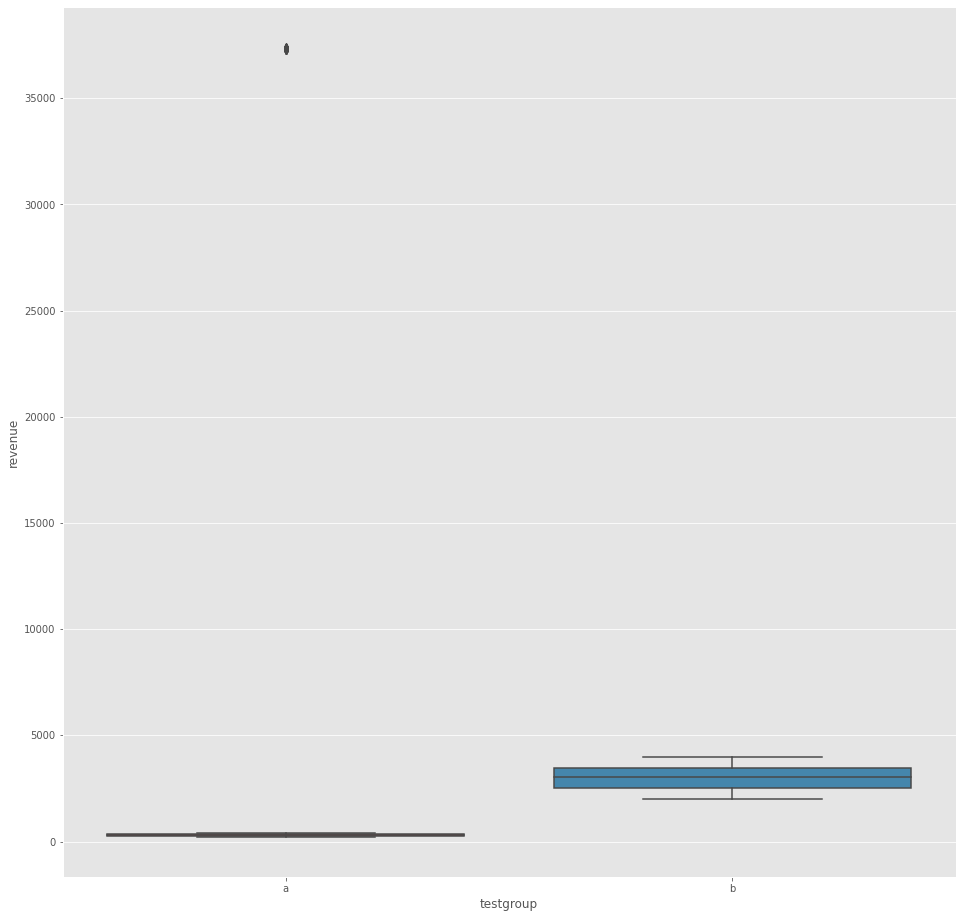

In [13]:
boxplot_builder(df.query('revenue != 0'))

# sns.swarmplot(x=df.testgroup, y=df.revenue)

In [9]:
df_test.head(1)

,user_id,revenue,testgroup
72,73,351,a


#### Часть чеков на большие суммы в группе а похожа на выбросы. Попробую сравнить группы без этих чеков.

<AxesSubplot:xlabel='testgroup', ylabel='revenue'>

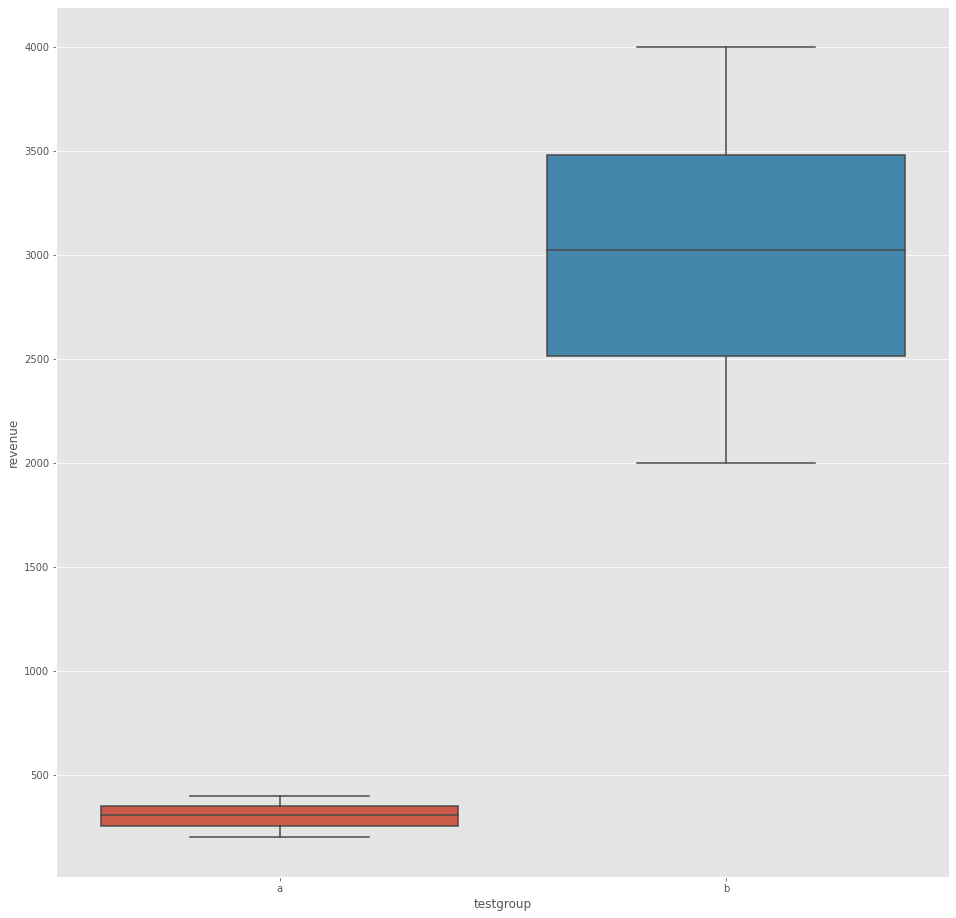

In [11]:
df_test = df.query('revenue != 0 & revenue < 35000')

boxplot_builder(df_test)

#### Выводы: 

Возможно, акционное предложение группы А содержит очень выгодные условия при покупке аксессуаров в игре на большую сумму (или, например, при  покупке подписки на длительный срок). Такие покупки, как оказалось, смогло себе позволить лишь относительно небольшое количество клиентов.

И, возможно, поэтому было выпущено акционное предложение Б, составленное таким образом, что практически все воспользовавшиеся предложением пользователи сделали покупки на бОльшие суммы.

####  Смотрю какой вклад в общий объем продаж в группе А привносят "выбросы"

In [23]:
whales = round(100 * df.query('revenue > 500 & testgroup == "a"').user_id.nunique()/df.user_id.nunique(), 2) 

print(f'Процент "китов" относительно всех пользователей в группе А составил {whales}% .')

print(f'Процент дохода от "китов" из группы А относительно всех пользователей составил {100 * round(control.query("revenue > 500").revenue.sum()/test.revenue.sum(), 2)}%.')

Процент "китов" относительно всех пользователей в группе А составил 0.03% .
Процент дохода от "китов" из группы А относительно всех пользователей составил 85.0%.


#### Выбор метрик:

CR = количество купивших пользователей / общее количество пользователей

ARPU = CR * доход / количество клиентов

#### Проверю нормальность распредлений revenue в тестовой и контрольной группах при помощи теста Шапиро-Уилка:

In [25]:
# Создаю функцию для проверки распределений на нормальность:

def norm_test(serie):
    
    stat, p = scipy.stats.shapiro(serie)
    
    alpha = 0.05
    if p > alpha:
        outcome = 'Принимаю гипотезу о нормальности'
    else:
        outcome = 'Отклоняю гипотезу о нормальности'
        
    return print(outcome)

In [ ]:
# Проверяю тестовую группу:

In [44]:
norm_test(test.query('revenue > 0').revenue.sample(1000))

Statistics=0.957, p-value=0.000
Отклоняю гипотезу о нормальности


In [41]:
# Проверяю контрольную группу с выбросами:

In [45]:
norm_test(control.query('revenue > 0').revenue.sample(1000))

Statistics=0.275, p-value=0.000
Отклоняю гипотезу о нормальности


In [24]:
# Проверяю контрольную группу без выбросов:

In [26]:
norm_test(control.query('revenue > 0 & revenue < 3500').revenue.sample(1000))

Отклоняю гипотезу о нормальности


#### Проверю гомогенность дисперсий в тестовой и контрольной группах:

H0 - различия дисперсии в тестовой и контрольной группах статистически не значимы;
H1 - различия дисперсии в тестовой и контрольной группах статистически значимы.

In [9]:
def levene_test(serie1, serie2):
    
    outcome = levene(serie1, serie2)
         
    alpha = 0.05
    
    if outcome[1] > alpha:
        print(f'Результат теста: {levene(serie1, serie2)}')
        outcome = f'Поскольку p-value > {alpha} - принимаю гипотезу о равенстве дисперсий.'
    else:
        print(f'Результат теста: {levene(serie1, serie2)}')
        outcome = f'Поскольку p-value < {alpha} - отклоняю гипотезу о равенстве дисперсий.'
        
    return print(outcome)

In [31]:
# В группе с выбросами:

levene_test(test.revenue, control.revenue)

Результат теста: LeveneResult(statistic=0.3896289474701388, pvalue=0.5324948591043842)
Поскольку p-value > 0.05 - принимаю гипотезу о равенстве дисперсий.


In [32]:
# В группе без выбросов:

levene_test(test.revenue, control.query('revenue < 3500').revenue)

Результат теста: LeveneResult(statistic=1400.7231388579885, pvalue=4.912187546515184e-306)
Поскольку p-value < 0.05 - отклоняю гипотезу о равенстве дисперсий.


#### Поскольку из условий задачи не известно чем конкретно вызваны выбросы в контрольной группе принимаю решение исследовать отдельно вариант с выбросами и без выбросов.

#### С выбросами:

In [83]:
# Считаю CR для тестовой группы:

CR_test = 100* test.query('revenue > 0').shape[0] / test.shape[0]

CR_test

0.8906235351586593

In [ ]:
# Считаю CR для контрольной группы:

In [82]:
CR_control = 100 * control.query('revenue > 0').shape[0] / control.shape[0]

CR_control

0.9539690157988748

#### Проверю является ли отличие CR статистически значимым:

Формулирую гипотезу:
H0 - конверсия в контрольной и тестовой группах значимо не различаются;
H1 - конверсия в контрольной и тестовой группах значимо различаются.

In [71]:
T = np.array([[control.query('revenue > 0').shape[0], control.query('revenue == 0').shape[0]], 
              [test.query('revenue > 0').shape[0], test.query('revenue == 0').shape[0]]])
              
print(chi2_contingency(T, correction=False)[1])

0.0350285246428554


#### В связи с тем что р-value < 0.05 я отвергаю Н0 о том, что статистически значимых различий между тестовой и контрольной группами нет.

In [72]:
# Считаю доход / количество клиентов или ARPPU:

In [73]:
# в тестовой группе:

ARPPU_test = test.revenue.sum() / test.query('revenue > 0').shape[0]

print(ARPPU_test)

3003.6581717451522


In [74]:
# в контрольной группе:

ARPPU_control = control.revenue.sum() / control.query('revenue > 0').shape[0]

print(ARPPU_control)

2663.9984439834025


#### Использую t-test для проверки статистической значимости изменения ARPPU:

Формулирую гипотезу: H0 - средние значения revenue в контрольной и тестовой группах платящих пользователей значимо не различаются; H1 - средние значения revenue в контрольной и тестовой группах платящих пользователей значимо различаются.

In [28]:
def ttest(serie1, serie2):
    
    outcome = ttest_ind(serie1, serie2)
         
    alpha = 0.05
    
    if outcome[1] > alpha:
        print(f'Результат теста: {ttest_ind(serie1, serie2)}')
        outcome = f'Поскольку p-value > {alpha} - принимаю гипотезу о равенстве выборочных средних.'
    else:
        print(f'Результат теста: {ttest_ind(serie1, serie2)}')
        outcome = f'Поскольку p-value < {alpha} - отклоняю гипотезу о равенстве выборочных средних.'
        
    return print(outcome)

In [29]:
ttest(test.revenue, control.revenue)

Результат теста: Ttest_indResult(statistic=0.6242026493616787, pvalue=0.532494858971837)
Поскольку p-value > 0.05 - принимаю гипотезу о равенстве выборочных средних.


#### Считаю ARPU:

In [84]:
# В тестовой группе:

ARPU_test = CR_test * ARPPU_test

ARPU_test

2675.128659327863

In [86]:
# в контрольной группе:

ARPU_control = CR_control * ARPPU_control

ARPU_control

2541.3719736965804

#### Использую t-test для проверки статистической значимости изменения ARPU:
Формулирую гипотезу: H0 - средние значения revenue в контрольной и тестовой группах пользователей значимо не различаются; H1 - средние значения revenue в контрольной и тестовой группах пользователей значимо различаются.

In [ ]:
def ttest(serie1, serie2):
    
    outcome = ttest_ind(serie1, serie2)
         
    alpha = 0.05
    
    if outcome[1] > alpha:
        print(f'Результат теста: {ttest_ind(serie1, serie2)}')
        outcome = f'Поскольку p-value > {alpha} - принимаю гипотезу о равенстве выборочных средних.'
    else:
        print(f'Результат теста: {ttest_ind(serie1, serie2)}')
        outcome = f'Поскольку p-value < {alpha} - отклоняю гипотезу о равенстве выборочных средних.'
        
    return print(outcome)

#### Промежуточный вывод:

#### Cценарий без выбросов:

In [87]:
# Считаю CR для тестовой группы:

CR_test = 100* test.query('revenue > 0').shape[0] / test.shape[0]

CR_test

0.8906235351586593

In [90]:
# Считаю CR для контрольной группы:

CR_test = 100* control.query('revenue > 0 & revenue < 3500').shape[0] / control.shape[0]

CR_test

0.8931089592930338

In [ ]:
#### 

In [91]:
T = np.array([[control.query('revenue > 0 & revenue < 3500').shape[0], control.query('revenue == 0').shape[0]], 
              [test.query('revenue > 0').shape[0], test.query('revenue == 0').shape[0]]])
              
print(chi2_contingency(T, correction=False)[1])

0.9183866495500783


#### В связи с тем что р-value > 0.05 то тест показывает что статистически значимых различий нет.

In [ ]:
# Считаю доход / количество клиентов или ARPPU:

In [94]:
# в тестовой группе:

ARPPU_test = test.revenue.sum() / test.query('revenue > 0').shape[0]

print(ARPPU_test)

3003.6581717451522


In [96]:
# в контрольной группе:

ARPPU_control = control.query('revenue < 3500').revenue.sum() / control.query('revenue > 0 & revenue < 3500').shape[0]

print(ARPPU_control)

302.45817174515236


#### Использую t-test c поправкой Уэлча для проверки статистической значимости изменения ARPPU:

Формулирую гипотезу: H0 - средние значения revenue в контрольной и тестовой группах платящих пользователей значимо не различаются; H1 - ARPPU в контрольной и тестовой группах платящих пользователей значимо различаются.

In [42]:
def ttest_welch(serie1, serie2):
    
    outcome = ttest_ind(serie1, serie2, equal_var=False)
         
    alpha = 0.05
    
    if outcome[1] > alpha:
        print(f'Результат теста: {ttest_ind(serie1, serie2)}')
        outcome = f'Поскольку p-value > {alpha} - принимаю гипотезу о равенстве выборочных средних.'
    else:
        print(f'Результат теста: {ttest_ind(serie1, serie2)}')
        outcome = f'Поскольку p-value < {alpha} - отклоняю гипотезу о равенстве выборочных средних.'
        
    return print(outcome)

In [46]:
ttest_welch(test.revenue, control.query('revenue > 0 & revenue < 3500').revenue)

Результат теста: Ttest_indResult(statistic=-40.760030297234856, pvalue=0.0)
Поскольку p-value < 0.05 - отклоняю гипотезу о равенстве выборочных средних.


In [92]:
#### Считаю ARPU:

ARPU_test = CR_test * ARPPU_test

ARPU_test

2682.5940238393296

In [93]:
ARPU_control = CR_control * ARPPU_control

ARPU_control

2541.3719736965804

In [47]:
#### Проверю ARPU

In [48]:
ttest_welch(test.revenue, control.query('revenue < 3500').revenue)

Результат теста: Ttest_indResult(statistic=37.42623596967759, pvalue=4.912187544972622e-306)
Поскольку p-value < 0.05 - отклоняю гипотезу о равенстве выборочных средних.


In [ ]:
get_bootstrap(test, control) # как есть без фильтров

In [ ]:
#### Финальный вывод. Может быть стоит оформить задачу как исследование а не как тестовое задание??

In [78]:
# pip install ipywidgets widgetsnbextension pandas-profiling

In [222]:
control.head()

,user_id,revenue,testgroup,arpu
1,2,0,a,0.0
2,3,0,a,0.0
9,10,0,a,0.0
10,11,0,a,0.0
11,12,0,a,0.0


#### Задание 3:

В игре Plants & Gardens каждый месяц проводятся тематические события, ограниченные по времени. В них игроки могут получить 
уникальные предметы для сада и персонажей, дополнительные монеты или бонусы. Для получения награды требуется пройти ряд 
уровней за определенное время. С помощью каких метрик можно оценить результаты последнего прошедшего события?

#### Решение: 

Я бы оценивал результаты последнего прошедшего события при помощт слдующих метрик:

ARPU = Revenue / Количество пользователей - покажет насколько прошедшее событие повлияло на увеличение дохода от каждого игрока;

ARPPU = Revenue / Количество платящих пользователей - покажет насколько событие помогло увеличить доход платящих игроков;

CR - изменение конверсии покажет насколько позитивно событие повлияло на принятие решения о покупке, стоит ли менять бонусные предложения;

Retnetion - динамика retention поможет оценить насколько событие влияет на удержание игрока;

Stickness ratio = DAU/MAU . Если метрика выросла - событие хорошо повлияло на вовлеченность игрока;

ASL - покажет насколько изменилось время, которое игрок проводит в игре. Тоже покажет динамику вовлеченности игрока;

#### Предположим, в другом событии мы усложнили механику событий так, что при каждой неудачной попытке выполнения уровня игрок будет откатываться на несколько уровней назад. Изменится ли набор метрик оценки результата? Если да, то как?

При усложнении механики я бы вместо retention обратил внимание на churn rate - сколько пользователей перестает играть.